In [1]:
# Set seed
SEED = 3
import random
import numpy as np
import tensorflow as tf # tf backend

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Imports
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
from IPython.display import Image
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import utils

In [2]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir('data'):
    raise Exception("Dataset splits not found. Please run main file to generate them.")

with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       581
           1       0.74      0.22      0.34        77

    accuracy                           0.90       658
   macro avg       0.82      0.61      0.64       658
weighted avg       0.89      0.90      0.87       658



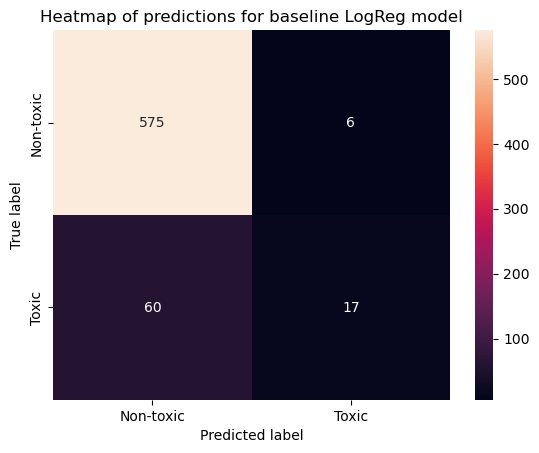

In [3]:
# load baseline model

if "baseline_lr.pkl" not in os.listdir('models') or "X_test_baseline.pkl" not in os.listdir('data'):
    raise Exception("Baseline model or test split not found. Please run main file to generate it.")

with open("models/baseline_lr.pkl", "rb") as f:
    lr = pickle.load(f)
    
with open("data/X_test_baseline.pkl", "rb") as f:
    X_test_baseline = pickle.load(f)

# make predictions and evaluate model
lr_pred = lr.predict(X_test_baseline)
print(classification_report(y_test, lr_pred))

lr_cm = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
utils.plot_heatmap(lr_cm, title="Heatmap of predictions for baseline LogReg model", save=False, file_name=None)

21/21 [==============================] - 0s 11ms/step

               precision    recall  f1-score   support

           0       0.93      0.97      0.95       581
           1       0.65      0.42      0.51        77

    accuracy                           0.91       658
   macro avg       0.79      0.69      0.73       658
weighted avg       0.89      0.91      0.90       658



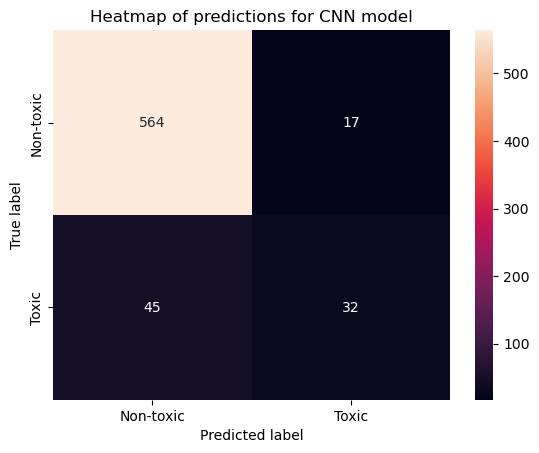

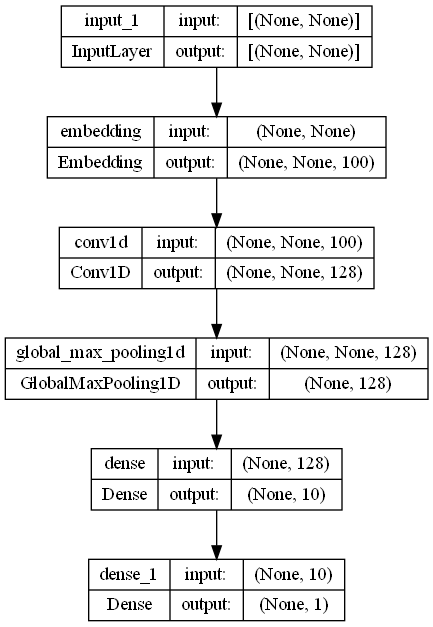

In [4]:
# load cnn model

if "cnn_model.keras" not in os.listdir('models'):
    raise Exception("CNN model not found. Please run main file to generate it.")

cnn = tf.keras.models.load_model('models/cnn_model.keras')
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)

# make predictions
p = cnn.predict(X_test_padded)
pred = np.where(p > .5, 1, 0)

# print classification report and plot heatmap
print("\n", classification_report(y_test, pred))
cnn_cm = confusion_matrix(y_test, pred)
utils.plot_heatmap(cnn_cm, title="Heatmap of predictions for CNN model", save=False, file_name=None)

# Display model plot
Image(filename='models/cnn_model.png')

In [5]:
# load tokenizer
if "tokenizer.json" not in os.listdir("models"):
    raise Exception("Tokenizer not found. Please run main file to generate it.")

with open("models/tokenizer.json") as f:
    content = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(content)

# load stopwords
stop_words = nltk.corpus.stopwords.words("danish")

# load maxlen
if "maxlen.txt" not in os.listdir("models"):
    raise Exception("Value for max length not found. Please run main file to generate it.")

with open("models/maxlen.txt") as f:
    MAXLEN = int(f.read())

In [6]:
# predict new sentences using this model

sent = "Kriminelle damer" # change sentence accordingly
proba, pred = utils.predict_toxicity(sent, stop_words, tokenizer, MAXLEN, cnn)
print("Probability:", proba[0])
print("Prediction :", pred[0])

1/1 [==============================] - 0s 35ms/step
Probability: 0.7436549
Prediction : 1
